# Single timestep graph - Elliptic data set

In [1]:
# global imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import powerlaw
import seaborn as sns

from graphdatascience import GraphDataScience
from matplotlib.ticker import FormatStrFormatter
from tqdm.notebook import tqdm

# local imports
from GraphBuilder import extractTimestepNodes, getTimestepEdgelist
from AnalysisManager import AnalysisManager
from NodeMetrics import NodeMetrics
from GraphMetrics import GraphMetrics

#### Neo4j modules

In [2]:
manager = AnalysisManager("neo4j", "elliptic", "../data", outputs_base_location="../")
connector = GraphDataScience("bolt://localhost:7687", auth=("neo4j", "elliptic"))
node_metrics = NodeMetrics(connector, "elliptic", "node", "TRANSACTION")
graph_metrics = GraphMetrics(connector, "elliptic", "node", "TRANSACTION")

#### Networkx graph

In [3]:
edgelist = pd.read_csv("../data/elliptic_txs_edgelist.csv")
transactions_features = pd.read_csv("../data/elliptic_txs_features.csv", header=None)
extracted_nodes = extractTimestepNodes(transactions_features, timestep=1)
timestep_1_edgelist = getTimestepEdgelist(extracted_nodes, edgelist)
graphtype = nx.DiGraph()
graph = nx.from_pandas_edgelist(edgelist,
                                source="txId1",
                                target="txId2",
                                create_using=graphtype)

### Functions related to working with Networkx library

Note on shortest paths

The shortest paths are determined using Networkx class static method shortest_path_length() which returns pairs of node ID and a dictionary containing all its neighbours IDs and path lengths to them. <br>
In this case, the information is stored in a multidimensional array of heterogenious sizes of elements which store the origin node ID, destination node IDs and path lengths.

In [4]:
def getAllShortestPaths(graph):
    all_shortest_paths = []
    for (i,j) in nx.shortest_path_length(graph):
        all_shortest_paths.append([i, list(j.keys()), np.array(list(j.values()))])
    return all_shortest_paths

In [5]:
def getMeanOfShortestPaths(shortest_paths):
    summed_lengths = 0
    number_of_paths = 0
    for i in range(len(shortest_paths)):
        summed_lengths += (shortest_paths[i][2].sum())
        number_of_paths += sum(shortest_paths[i][2] != 0)

    return summed_lengths / number_of_paths

In [6]:
def getMedianOfShortestPaths(shortest_paths):
    all_paths_lengths = []
    for i in range(len(shortest_paths)):
        for path_length in shortest_paths[i][2]:
            all_paths_lengths.append(path_length)
    all_paths_lengths = pd.Series(np.array(all_paths_lengths))
    return all_paths_lengths.median()

In [7]:
def getDiameter(shortest_paths):
    all_paths_lengths = []
    for i in range(len(shortest_paths)):
        for path_length in shortest_paths[i][2]:
            all_paths_lengths.append(path_length)
    all_paths_lengths = pd.Series(np.array(all_paths_lengths))
    return all_paths_lengths.max()

In [8]:
def getDegreeDistribution(connector, nodes_and_classes):
    nodes = nodes_and_classes["id"]
    degree_df = None
    for node in tqdm(nodes):
        try:
            results_in_degree = connector.run_cypher("""
                            MATCH (n:node)<-[r:TRANSACTION]-(m:node)
                            WHERE n.id = '%s'
                            RETURN n.id AS id, count(m) AS in_degree
                            """ % node)
            results_out_degree = connector.run_cypher("""
                            MATCH (n:node)-[r:TRANSACTION]->(m:node)
                            WHERE n.id = '%s'
                            RETURN n.id AS id, count(m) AS out_degree
                            """ % node)

            merged = pd.merge(results_in_degree, results_out_degree, on="id", how="outer")

            if degree_df is None:
                degree_df = merged
            else:
                degree_df = pd.concat([degree_df, merged], axis=0)
        except:
            continue

    return degree_df.fillna(0)

## Large-scale Network Properties

In [9]:
nodes_classes = node_metrics.getNodesClasses()

In [10]:
degree_distribution_df = getDegreeDistribution(connector=connector, nodes_and_classes=nodes_classes)

  0%|          | 0/7880 [00:00<?, ?it/s]

In [11]:
column_names = ["Type", "n", "m", "c", "S", "l", "alpha_in", "alpha_out", "C"]
properties = ["Directed"]

Number of nodes

In [12]:
n = graph_metrics.getGraphSize()
properties.append(n)
print(n)

7880


Number of edges

In [13]:
m = graph_metrics.getNumberOfEdges().values[0][0]
properties.append(m)
print(m)

9164


Mean degree

In [14]:
c = 2 * m / n
properties.append(c)
print(c)

2.3258883248730964


Fraction of nodes in the giant component (the largest component)

In [15]:
fractions = pd.DataFrame(graph_metrics.getFractionsWeaklyConnectedComponents())
fractions = fractions.reset_index()
fractions.columns = ["componentId", "fraction_of_nodes"]
S = fractions[fractions["fraction_of_nodes"] == fractions["fraction_of_nodes"].max()]["fraction_of_nodes"][0]
properties.append(S)
print(S)

1.0


Mean distance between connected node pairs

In [16]:
l = getMeanOfShortestPaths(getAllShortestPaths(graph=graph))
properties.append(l)
print(l)

129.80861706805788


Exponent alpha

In [17]:
print(degree_distribution_df["in_degree"].value_counts())
print(degree_distribution_df["out_degree"].value_counts())
x1 = degree_distribution_df["in_degree"].values
x2 = degree_distribution_df["out_degree"].values
data1 = powerlaw.Fit(x1)
data2 = powerlaw.Fit(x2)
properties.append(data1.alpha)
properties.append(data2.alpha)

1      5051
0      1696
2       840
3       114
4        69
5        28
7        15
6        15
8         7
11        5
10        4
19        4
12        3
9         3
15        3
17        2
21        2
49        2
28        2
18        2
160       1
59        1
31        1
23        1
22        1
134       1
106       1
26        1
40        1
14        1
24        1
97        1
143       1
Name: in_degree, dtype: int64
1      4693
2      1883
0      1208
3        53
4        19
6         6
5         5
7         5
9         2
11        2
8         1
28        1
288       1
10        1
Name: out_degree, dtype: int64
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


In [18]:
print(data1.alpha)
print(data2.alpha)

2.921353729053532
29.63192774380923


Mean clustering coefficient

In [19]:
local_clustering_coefficients = node_metrics.getClusteringCoefficient()
C = local_clustering_coefficients["localClusteringCoefficient"].mean()
properties.append(C)
print(C)

0.0161683011464482


In [20]:
large_scale_structure_df = pd.DataFrame([properties])
large_scale_structure_df.columns = column_names
large_scale_structure_df.to_csv("../graph_large_scale_properties.csv")
large_scale_structure_df

,Type,n,m,c,S,l,alpha_in,alpha_out,C
0,Directed,7880,9164,2.325888,1.0,129.808617,2.921354,29.631928,0.016168


### Additional properties

Density

In [21]:
rho = (2 * m) / (n * (n - 1))
print(rho)

0.00029520095505433387


Number of strongly connected components

In [22]:
len(graph_metrics.getFractionsStronglyConnectedComponents())

7880

Number of weakly connected components

In [23]:
len(graph_metrics.getFractionsWeaklyConnectedComponents())

1

Graph's diameter

In [24]:
path_lengths = {}
all_shortest_paths = getAllShortestPaths(graph)
for i in range(len(all_shortest_paths)):
    for path in all_shortest_paths[i][2]:
        if path in path_lengths.keys():
            path_lengths[path] += 1
        else:
            path_lengths[path] = 1

In [25]:
path_lengths

{0: 203769,
 1: 234355,
 2: 236004,
 3: 226259,
 4: 184091,
 5: 143324,
 6: 117486,
 7: 99756,
 8: 87182,
 9: 78939,
 10: 72810,
 11: 67606,
 12: 63521,
 13: 60644,
 14: 57901,
 15: 55580,
 16: 53342,
 17: 51355,
 18: 49183,
 19: 47447,
 20: 45971,
 21: 44521,
 22: 43297,
 23: 41925,
 24: 40589,
 25: 39442,
 26: 38368,
 27: 37339,
 28: 36507,
 29: 35653,
 30: 34870,
 31: 34095,
 32: 33329,
 33: 32641,
 34: 31952,
 35: 31272,
 36: 30692,
 37: 30120,
 38: 29579,
 39: 28990,
 40: 28386,
 41: 27813,
 42: 27265,
 43: 26703,
 44: 26198,
 45: 25690,
 46: 25199,
 47: 24726,
 48: 24244,
 49: 23726,
 50: 23247,
 51: 22832,
 52: 22394,
 53: 21984,
 54: 21603,
 55: 21239,
 56: 20870,
 57: 20492,
 58: 20119,
 59: 19777,
 60: 19409,
 61: 19055,
 62: 18724,
 63: 18388,
 64: 18048,
 65: 17735,
 66: 17396,
 67: 17071,
 68: 16795,
 69: 16493,
 70: 16223,
 71: 15960,
 72: 15687,
 73: 15434,
 74: 15192,
 75: 14953,
 76: 14699,
 77: 14459,
 78: 14244,
 79: 14020,
 80: 13799,
 81: 13579,
 82: 13380,
 83: 13

In [26]:
getDiameter(getAllShortestPaths(graph=graph))

1248

## Centrality Metrics Analysis

#### Class imbalance

In [27]:
nodes_classes["class"].value_counts()

3    5733
2    2130
1      17
Name: class, dtype: int64

### Degree Distribution

In [28]:
degree_distribution_df.head()

,id,in_degree,out_degree
0,230425980,1,1
0,5530458,1,1
0,232022460,1,2
0,232438397,160,1
0,230460314,2,8


In [29]:
degree_distribution_df = degree_distribution_df.round(decimals=3)
degree_distribution_classes = pd.merge(degree_distribution_df, nodes_classes, on="id")

In [45]:
def plotInDegreeDistribution(x, y, color, title_postfix=""):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8,7))
    ax = sns.barplot(x=x, y=y, color=color)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.xlabel("in-degree")
    plt.ylabel("count")
    plt.title(f"In-degree distribution{title_postfix}", fontsize=16)
    plt.show()

def plotOutDegreeDistribution(x, y, color, title_postfix=""):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8,7))
    ax = sns.barplot(x=x, y=y, color=color)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    plt.xlabel("out-degree")
    plt.ylabel("count")
    plt.title(f"Out-degree distribution{title_postfix}", fontsize=16)
    plt.show()

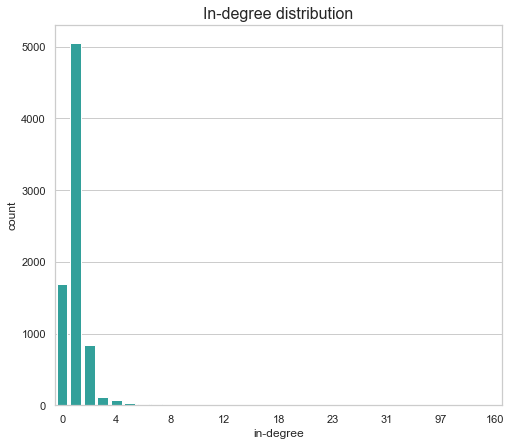

In [46]:
plotInDegreeDistribution(x=degree_distribution_df["in_degree"].value_counts().index, y=degree_distribution_df["in_degree"].value_counts(), color="lightseagreen")

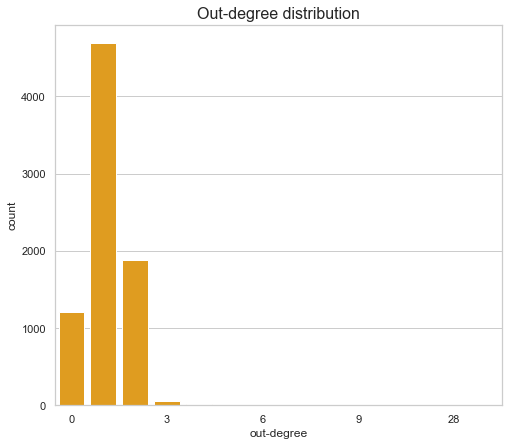

In [47]:
plotOutDegreeDistribution(x=degree_distribution_df["out_degree"].value_counts().index, y=degree_distribution_df["out_degree"].value_counts(), color="orange")

In [48]:
degree_distribution_classes[degree_distribution_classes["class"] == 1]["in_degree"].value_counts()

0    14
1     2
2     1
Name: in_degree, dtype: int64

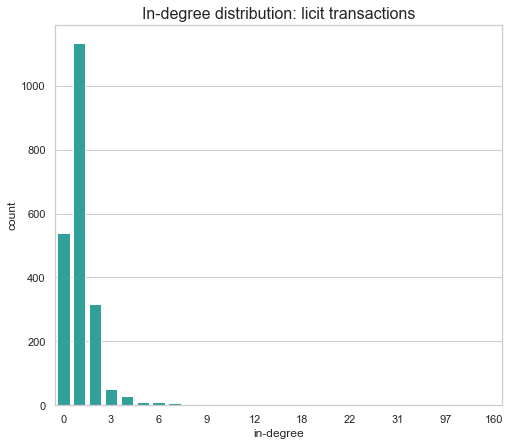

In [49]:
x = degree_distribution_classes[degree_distribution_classes["class"] == 2]["in_degree"].value_counts().index
y = degree_distribution_classes[degree_distribution_classes["class"] == 2]["in_degree"].value_counts()
plotInDegreeDistribution(x=x, y=y, color="lightseagreen", title_postfix=": licit transactions")

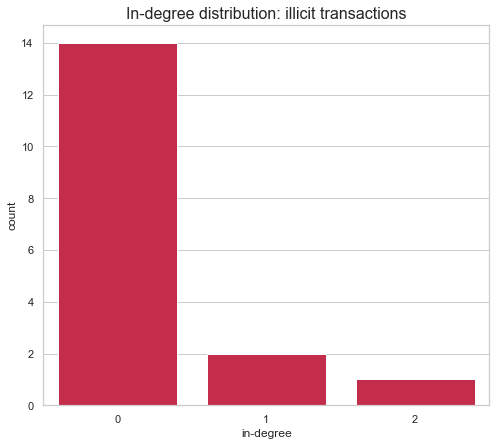

In [50]:
plt.figure(figsize=(8,7))
sns.barplot(x=degree_distribution_classes[degree_distribution_classes["class"] == 1]["in_degree"].value_counts().index, y=degree_distribution_classes[degree_distribution_classes["class"] == 1]["in_degree"].value_counts(), color="crimson")
plt.title("In-degree distribution: illicit transactions", fontsize=16)
plt.xlabel("in-degree")
plt.ylabel("count")
plt.show()

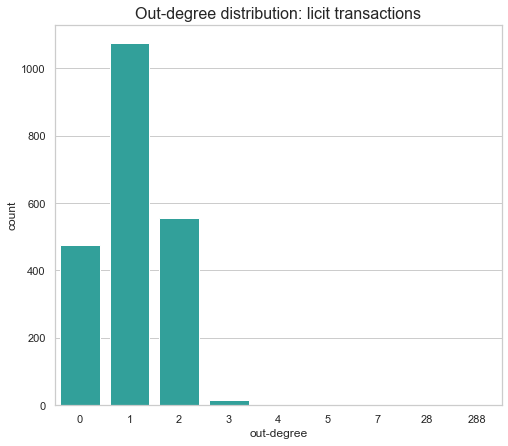

In [51]:
x = degree_distribution_classes[degree_distribution_classes["class"] == 2]["out_degree"].value_counts().index
y = degree_distribution_classes[degree_distribution_classes["class"] == 2]["out_degree"].value_counts()
plotOutDegreeDistribution(x=x, y=y, color="lightseagreen", title_postfix=": licit transactions")

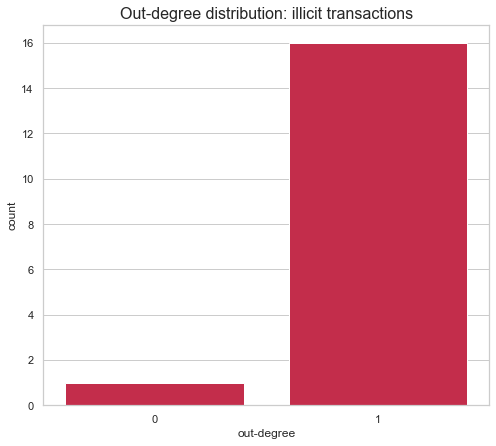

In [52]:
plt.figure(figsize=(8,7))
sns.barplot(x=degree_distribution_classes[degree_distribution_classes["class"] == 1]["out_degree"].value_counts().index, y=degree_distribution_classes[degree_distribution_classes["class"] == 1]["out_degree"].value_counts(), color="crimson")
plt.title("Out-degree distribution: illicit transactions", fontsize=16)
plt.xlabel("out-degree")
plt.ylabel("count")
plt.show()

### Mann-Whitney U test

In [106]:
from scipy.stats import mannwhitneyu

In [107]:
fraud_indegree_distribution = degree_distribution_classes[degree_distribution_classes["class"] == 1]["in_degree"]
fraud_outdegree_distribution = degree_distribution_classes[degree_distribution_classes["class"] == 1]["out_degree"]
non_fraud_indegree_distribution = degree_distribution_classes[degree_distribution_classes["class"] == 2]["in_degree"]
non_fraud_outdegree_distribution = degree_distribution_classes[degree_distribution_classes["class"] == 2]["out_degree"]

In [108]:
mw_result = mannwhitneyu(x=fraud_indegree_distribution, y=non_fraud_indegree_distribution, alternative="two-sided")
print("Mann-Whitney U test statistic: %5.3f" % mw_result.statistic)
print("p-value: %5.3f" % mw_result.pvalue)

Mann-Whitney U test statistic: 7807.000
p-value: 0.000


In [109]:
mw_result = mannwhitneyu(x=fraud_outdegree_distribution, y=non_fraud_outdegree_distribution, alternative="two-sided")
print("Mann-Whitney U test statistic: %5.3f" % mw_result.statistic)
print("p-value: %5.3f" % mw_result.pvalue)

Mann-Whitney U test statistic: 16454.000
p-value: 0.479


### Pagerank scores distribution

In [53]:
def plotPageRankDistribution(subset, color, title_postfix=""):
    subset = subset.value_counts()
    plt.figure(figsize=(8,7))
    sns.barplot(x=subset, y=subset.index, color=color)
    plt.xlabel("pagerank score")
    plt.xticks(rotation=45)
    plt.ylabel("count")
    plt.title(f"Pagerank scores distribution{title_postfix}")
    plt.show()

In [54]:
pagerank_scores = node_metrics.getPageRankScores().round(decimals=3)
pagerank_scores_classes = pd.merge(pagerank_scores, nodes_classes, on="id")

In [55]:
manager.getNodesMetrics()

,id,class,degree,EigenvectorCentrality,PageRankScore,BetweennessScore,ClosenessScore,authorityScore,hubScore
0,230425980,3,1.0,1.331093e-20,0.387650,14.000000,0.250000,4.208200e-49,2.473501e-50
1,5530458,3,1.0,4.466042e-18,0.479503,8.000000,0.222222,4.208200e-49,2.473501e-50
2,232022460,3,2.0,9.124115e-33,0.477994,30.000000,0.500000,4.208200e-49,2.104224e-04
3,232438397,2,1.0,1.686240e-08,26.485577,2355.000000,0.383550,3.567407e-03,2.473501e-50
4,230460314,3,8.0,9.129204e-33,0.201232,16.752381,0.750000,2.285641e-11,5.672538e-10
...,...,...,...,...,...,...,...,...,...
7875,230658152,3,1.0,2.628190e-44,0.150000,0.000000,0.000000,0.000000e+00,9.434011e-08
7876,54735200,2,0.0,2.544614e-36,0.331688,0.000000,0.666667,4.208200e-49,0.000000e+00
7877,230551382,3,1.0,2.628190e-44,0.150000,0.000000,0.000000,0.000000e+00,3.674932e-03
7878,33654709,3,0.0,3.956971e-40,0.213750,0.000000,1.000000,6.131404e-32,0.000000e+00


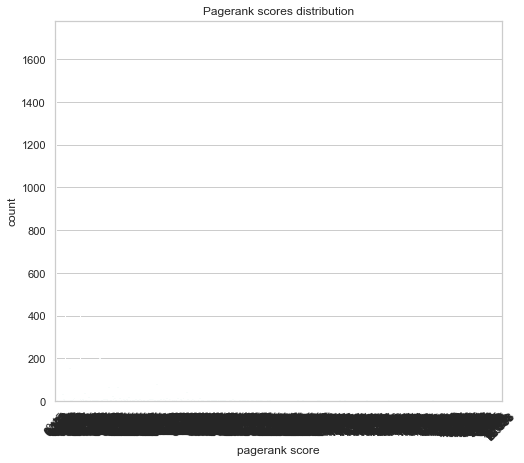

In [56]:
plt.figure(figsize=(8,7))
sns.barplot(x=pagerank_scores_classes["PageRankScore"].value_counts().index, y=pagerank_scores_classes["PageRankScore"].value_counts(), color="lightseagreen")
plt.xlabel("pagerank score")
plt.xticks(rotation=45)
plt.ylabel("count")
plt.title(f"Pagerank scores distribution")
plt.show()

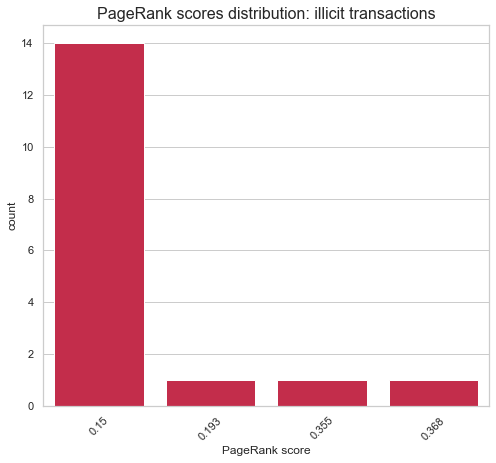

In [57]:
subset = pagerank_scores_classes[pagerank_scores_classes["class"] == 1]["PageRankScore"]
plt.figure(figsize=(8,7))
sns.barplot(x=subset.value_counts().index, y=subset.value_counts(), color="crimson")
plt.xlabel("PageRank score")
plt.xticks(rotation=45)
plt.ylabel("count")
plt.title(f"PageRank scores distribution: illicit transactions", fontsize=16)
plt.show()

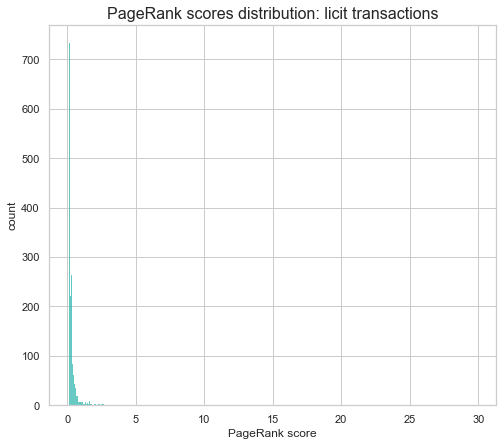

In [58]:
plt.figure(figsize=(8,7))
sns.histplot(pagerank_scores_classes[pagerank_scores_classes["class"] == 2]["PageRankScore"], color="lightseagreen")
plt.title("PageRank scores distribution: licit transactions", fontsize=16)
plt.ylabel("count")
plt.xlabel("PageRank score")
plt.show()

In [59]:
pagerank_scores_classes[pagerank_scores_classes["class"] == 1]["PageRankScore"].value_counts()

0.150    14
0.193     1
0.368     1
0.355     1
Name: PageRankScore, dtype: int64

### Mann-Whitney U test

In [113]:
pagerank_distributions = pd.merge(nodes_classes, pagerank_scores, on="id")

In [114]:
fraud_pagerank_distribution = pagerank_scores[pagerank_distributions["class"] == 1]["PageRankScore"]
non_fraud_pagerank_distribution = pagerank_distributions[pagerank_distributions["class"] == 2]["PageRankScore"]

In [115]:
mw_result = mannwhitneyu(x=fraud_pagerank_distribution, y=non_fraud_pagerank_distribution, alternative="two-sided")
print("Mann-Whitney U test statistic: %5.3f" % mw_result.statistic)
print("p-value: %5.3f" % mw_result.pvalue)

Mann-Whitney U test statistic: 14590.500
p-value: 0.164


### Betweenness scores distribution

In [60]:
betweenness_scores = node_metrics.getBetweennessCentrality()
print(betweenness_scores["BetweennessScore"].max())
print(betweenness_scores["BetweennessScore"].min())

14256.0
0.0


### Eigenvector scores distribution

In [61]:
def plotEigenvectorScoresDistribution(subset, color, title_postfix=""):
    subset = subset.value_counts()
    plt.figure(figsize=(8,7))
    sns.barplot(x=subset.index, y=subset, color=color)
    plt.xlabel("eigenvector score")
    plt.xticks(rotation=45)
    plt.ylabel("count")
    plt.title(f"Eigenvector scores distribution{title_postfix}")
    plt.show()

In [62]:
eigenvector_scores = node_metrics.getEigenvectorCentrality().round(decimals=3)

In [63]:
eigenvector_scores_classes = pd.merge(eigenvector_scores, nodes_classes, on="id")

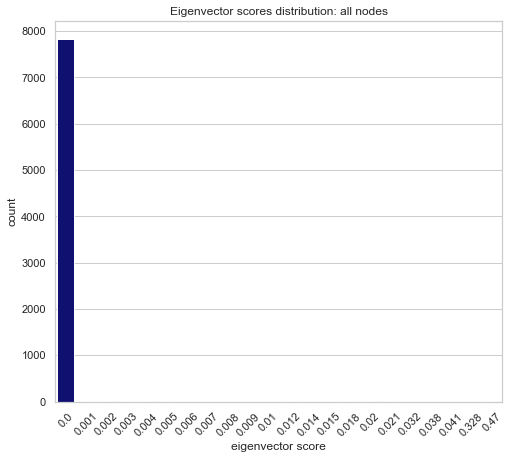

In [65]:
plotEigenvectorScoresDistribution(eigenvector_scores["EigenvectorCentrality"], color="navy", title_postfix=": all nodes")

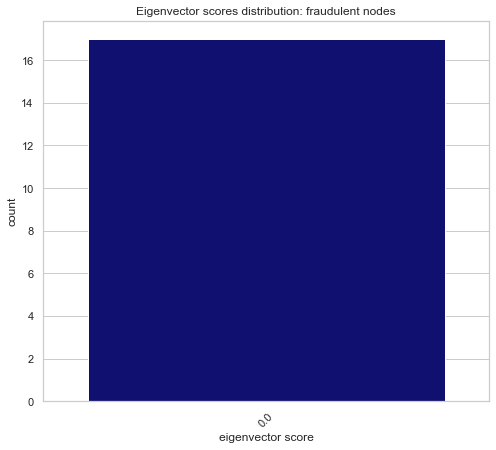

In [66]:
plotEigenvectorScoresDistribution(eigenvector_scores_classes[eigenvector_scores_classes["class"] == 1]["EigenvectorCentrality"], color="navy", title_postfix=": fraudulent nodes")

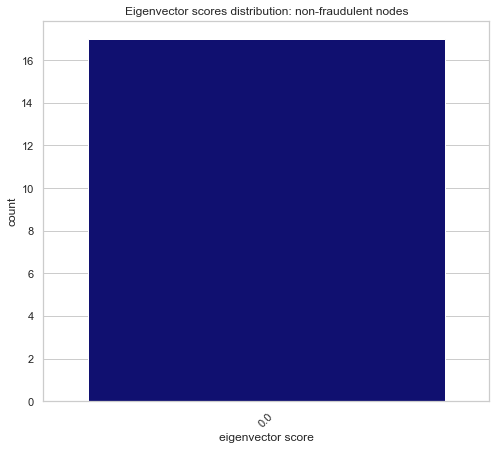

In [67]:
plotEigenvectorScoresDistribution(eigenvector_scores_classes[eigenvector_scores_classes["class"] == 1]["EigenvectorCentrality"], color="navy", title_postfix=": non-fraudulent nodes")

### Closeness Centrality Distribution

In [68]:
def plotClosenessScoresDistribution(subset, color, title_postfix=""):
    subset = subset.value_counts()
    plt.figure(figsize=(8,7))
    ax = sns.barplot(x=subset.index, y=subset, color=color)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.xlabel("closeness score")
    plt.ylabel("count")
    plt.title(f"Closeness scores distribution{title_postfix}", fontsize=16)
    plt.show()

In [69]:
closeness_scores = node_metrics.getClosenessCentrality()

In [70]:
closeness_scores_classes = pd.merge(closeness_scores, nodes_classes, on="id")

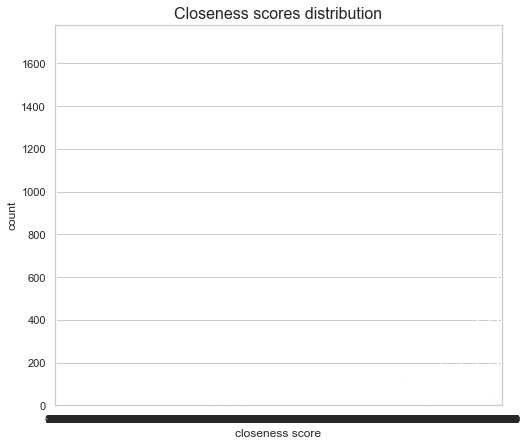

In [72]:
plotClosenessScoresDistribution(closeness_scores["ClosenessScore"], color="orange")

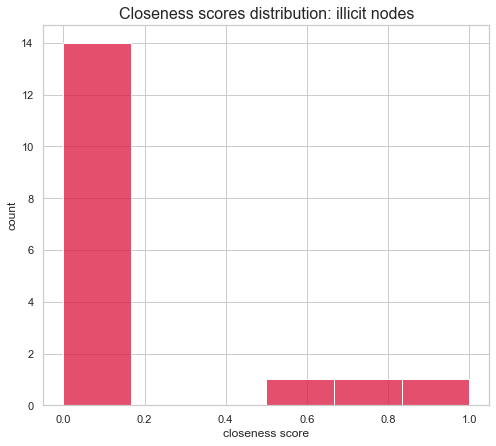

In [73]:
plt.figure(figsize=(8,7))
sns.histplot(closeness_scores_classes[closeness_scores_classes["class"] == 1]["ClosenessScore"], color="crimson")
plt.xlabel("closeness score")
plt.ylabel("count")
plt.title(f"Closeness scores distribution: illicit nodes", fontsize=16)
plt.show()

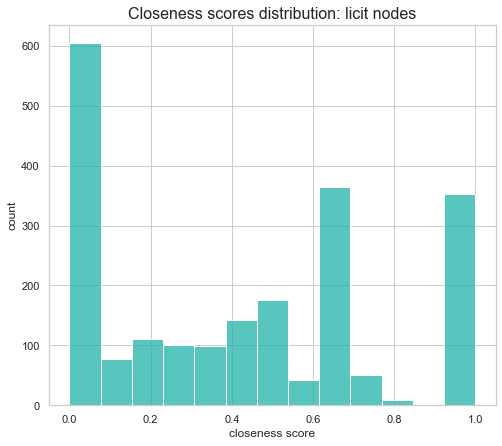

In [74]:
plt.figure(figsize=(8,7))
sns.histplot(closeness_scores_classes[closeness_scores_classes["class"] == 2]["ClosenessScore"], color="lightseagreen")
plt.xlabel("closeness score")
plt.ylabel("count")
plt.title(f"Closeness scores distribution: licit nodes", fontsize=16)
plt.show()

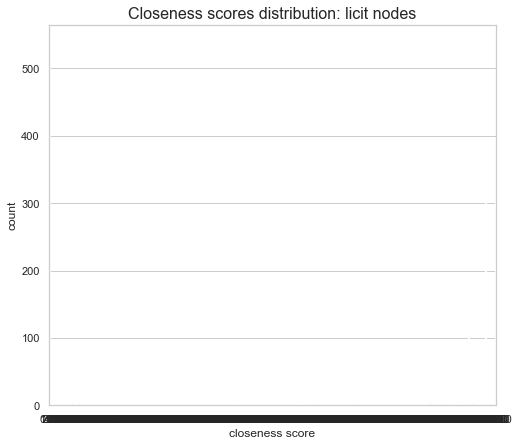

In [75]:
plotClosenessScoresDistribution(closeness_scores_classes[closeness_scores_classes["class"] == 2]["ClosenessScore"], color="crimson", title_postfix=": licit nodes")

### Mann-Whitney U test

In [116]:
closeness_distributions = pd.merge(nodes_classes, closeness_scores, on="id")

In [117]:
fraud_closeness_distribution = closeness_scores[closeness_distributions["class"] == 1]["ClosenessScore"]
non_fraud_closeness_distribution = closeness_distributions[closeness_distributions["class"] == 2]["ClosenessScore"]

In [118]:
mw_result = mannwhitneyu(x=fraud_closeness_distribution, y=non_fraud_closeness_distribution, alternative="two-sided")
print("Mann-Whitney U test statistic: %5.3f" % mw_result.statistic)
print("p-value: %5.3f" % mw_result.pvalue)

Mann-Whitney U test statistic: 11803.000
p-value: 0.012


### HITS scores distribution

In [76]:
hits_scores = node_metrics.getHITSCentrality()
hits_scores_classes = pd.merge(hits_scores, nodes_classes, on="id")

In [77]:
hits_scores_classes.round(decimals=3)["authorityScore"].idxmax(), hits_scores_classes.round(decimals=3)["authorityScore"].max()

(2518, 0.065)

In [78]:
hits_scores_classes.iloc[2518]

id                230537117
authorityScore     0.065151
hubScore                0.0
class                     3
Name: 2518, dtype: object

In [79]:
hits_scores_classes.round(decimals=3)["hubScore"].idxmax(), hits_scores_classes.round(decimals=3)["hubScore"].max()

(7745, 0.997)

In [80]:
hits_scores_classes.iloc[7745]

id                   89273
authorityScore         0.0
hubScore          0.997373
class                    2
Name: 7745, dtype: object

In [82]:
hits_scores_classes["authorityScore"].round(decimals=3).value_counts()

0.000    7565
0.059     264
0.001      24
0.060      10
0.061       7
0.063       3
0.002       2
0.064       2
0.062       1
0.065       1
0.004       1
Name: authorityScore, dtype: int64

In [83]:
hits_scores_classes[hits_scores_classes["class"] == 1]["authorityScore"].round(decimals=3).value_counts()

0.0    17
Name: authorityScore, dtype: int64

In [84]:
hits_scores_classes[hits_scores_classes["class"] == 2]["authorityScore"].round(decimals=3).value_counts()

0.000    1861
0.059     228
0.001      22
0.061       6
0.060       6
0.002       2
0.063       2
0.064       1
0.004       1
0.062       1
Name: authorityScore, dtype: int64

In [85]:
hits_scores_classes["hubScore"].round(decimals=3).value_counts()

0.000    7526
0.004     248
0.003      97
0.007       6
0.008       1
0.997       1
0.019       1
Name: hubScore, dtype: int64

In [86]:
hits_scores_classes[hits_scores_classes["class"] == 1]["hubScore"].round(decimals=3).value_counts()

0.000    15
0.004     2
Name: hubScore, dtype: int64

In [87]:
hits_scores_classes[hits_scores_classes["class"] == 2]["hubScore"].round(decimals=3).value_counts()

0.000    2004
0.004      71
0.003      48
0.007       5
0.997       1
0.019       1
Name: hubScore, dtype: int64

## Louvain Communities Analysis

In [88]:
def getClassesDistributionInAllCommunities(analysis_manager, save=False, output_directory=None):
    communities_distribution = analysis_manager.getNodeClassesInCommunities().groupby("communityId")["class"].value_counts()
    content = pd.DataFrame(communities_distribution)
    content.columns = ["frequency"]
    content = content.reset_index()

    if save & (output_directory is not None):
        try:
            with open(f"{output_directory}/classes_distribution_in_louvain_communities.txt", 'w') as fh:
                fh.write(f"{content.to_string(header=True, index=True)}\n")

        except Exception as e:
            print("Saving the contents failed. Error message: %s" % e)

    return content

def getSuspiciousCommunities(classes_distribution_in_communities):
    """
    :param classes_distribution_in_communities: a dataframe containing all communities' IDs and all transaction classes.
    :return: a dataframe of communities which can be considered suspicious, potentially a fraud ring.
    """
    communities_illicit = classes_distribution_in_communities[classes_distribution_in_communities["class"] == 1]["communityId"]
    communities_illicit = pd.DataFrame(communities_illicit)
    communities_illicit.columns = ["communityId"]
    return communities_illicit

def getClassesDistributionInSuspiciousCommunities(suspicious_communities, classes_distribution_in_communities):
    return pd.merge(suspicious_communities, classes_distribution_in_communities, on="communityId")

In [89]:
def getSuspiciousCommunitiesFlow(analysis_manager, suspicious_communities):

    transactions_flow = None

    classes_assigned = analysis_manager.getNodeClassesInCommunities()
    node_ids = pd.merge(classes_assigned, suspicious_communities, on="communityId")["id"]
    str1 = f"{list(node_ids)}"

    try:
        gds = GraphDataScience("bolt://localhost:7687", auth=("neo4j", "elliptic"))
        transactions_flow = gds.run_cypher("MATCH (n:node)-[r:TRANSACTION]->(m:node) WHERE n.id IN %s RETURN n.id AS txId1, n.class AS txId1_class, r.cost AS weight, m.id AS txId2, m.class AS txId2_class" % str1)
        gds.close()
    except Exception as e:
        print("Error occurred. Check if the database is online. Error message: %s" % e)

    return transactions_flow

### Degree distribution in communities

In [90]:
communities = manager.detectLouvainCommunities()

In [91]:
nodes_class = node_metrics.getNodesClasses()

In [92]:
sum(nodes_class["class"] == 1)

17

In [93]:
degree_distribution_in_communities = pd.merge(communities, degree_distribution_df, on="id")
degree_class_in_communities = pd.merge(degree_distribution_in_communities, nodes_class, on="id")
degree_class_in_communities[degree_class_in_communities["class"] == 1]

,id,communityId,intermediateCommunityIds,in_degree,out_degree,class
367,16742787,7767,None,0,1,1
368,16753577,975,None,0,1,1
369,16754007,5631,None,0,1,1
378,17387772,1080,None,1,1,1
389,17796937,2026,None,0,1,1
429,184703182,7668,None,0,1,1
1094,230389796,1080,None,0,1,1
3631,231990430,919,None,0,1,1
3632,231990435,919,None,0,1,1
3933,232014511,2228,None,1,1,1


In [94]:
degree_class_in_communities

,id,communityId,intermediateCommunityIds,in_degree,out_degree,class
0,100197784,211,None,1,1,3
1,100197901,6373,None,1,1,3
2,100256600,61,None,1,1,3
3,10033979,6918,None,1,0,3
4,10039990,2026,None,0,1,3
...,...,...,...,...,...,...
7875,99506348,1119,None,1,1,3
7876,99506349,7115,None,1,1,3
7877,99600686,1050,None,1,0,2
7878,99606749,4053,None,1,1,3


### Transactions of each class - frequencies in communities

In [95]:
communities_classes_distribution = getClassesDistributionInAllCommunities(manager, save=True, output_directory="../")
suspicious_communities = getSuspiciousCommunities(communities_classes_distribution)
getClassesDistributionInSuspiciousCommunities(suspicious_communities, communities_classes_distribution)

,communityId,class,frequency
0,847,3,26
1,847,2,2
2,847,1,1
3,919,3,11
4,919,2,8
5,919,1,2
6,973,2,6
7,973,3,6
8,973,1,1
9,975,3,10


### Studying the transactions flow

In [96]:
transaction_flow_in_suspicious_communities = getSuspiciousCommunitiesFlow(manager,
                                                                          suspicious_communities=suspicious_communities)

In [97]:
transaction_flow_in_suspicious_communities

,txId1,txId1_class,weight,txId2,txId2_class
0,232438397,2,1,92491280,2
1,27553029,2,1,230411688,2
2,232658952,3,1,62195631,1
3,232658952,3,1,232658962,3
4,230432611,2,1,71372878,3
...,...,...,...,...,...
297,232042947,2,1,232438397,2
298,3205536,1,1,230451730,2
299,230471948,3,1,232438397,2
300,230455503,3,1,232438397,2


As seen below, because the transaction is directed from nameOrig to nameDest, we can see that illicit transactions changed their status, as their counts dropped for txId2 classes. The number of licit transactions (2) increased, the number of unknown class transaction decreased as well.

In [98]:
def getTransactionsFlowDf(value_counts_transactions):
    transactions_flow_df = pd.DataFrame(value_counts_transactions)
    transactions_flow_df= transactions_flow_df.reset_index()
    transactions_flow_df.columns = ["transaction_class", "frequency"]
    return transactions_flow_df

In [99]:
flow_from = getTransactionsFlowDf(transaction_flow_in_suspicious_communities.txId1_class.value_counts())
flow_from

,transaction_class,frequency
0,3,155
1,2,131
2,1,16


In [100]:
flow_to = getTransactionsFlowDf(transaction_flow_in_suspicious_communities.txId2_class.value_counts())
flow_to

,transaction_class,frequency
0,2,208
1,3,91
2,1,3


In [101]:
def plotTransactionsFlowClasses(value_counts_transactions_flow1, value_counts_transactions_flow2):
    fig, ax = plt.subplots(ncols=2, figsize=(8, 6))
    sns.barplot(data=value_counts_transactions_flow1, x="transaction_class", y="frequency", ax=ax[0])
    sns.barplot(data=value_counts_transactions_flow2, x="transaction_class", y="frequency", ax=ax[1])
    ax[0].set_xlabel("Transaction class", fontsize=12)
    ax[1].set_xlabel("Transaction class", fontsize=12)
    ax[0].set_ylabel("Frequency", fontsize=12)
    ax[1].set_ylabel("Frequency", fontsize=12)
    ax[0].set_title("Transaction origin's entity", fontsize=14)
    ax[1].set_title("Transaction destination's entity", fontsize=14)
    plt.tight_layout()
    plt.show()

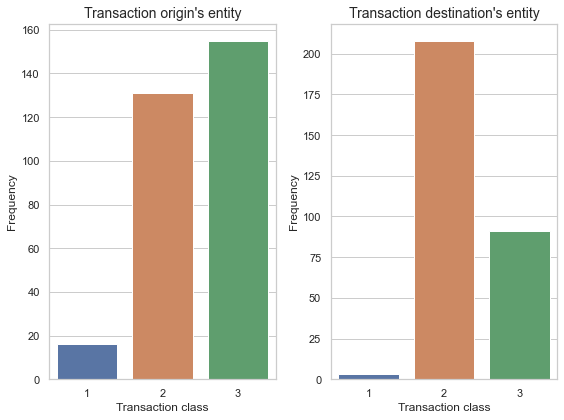

In [102]:
plotTransactionsFlowClasses(flow_from, flow_to)

In [103]:
connector.close()

## Mann-Whitney Test

In [ ]:
from scipy.stats import mannwhitneyu

### Degree distributions

In [ ]:
fraud_indegree_distribution = degree_distribution_and_class[degree_distribution_and_class["class"] == 1]["in_degree"]
fraud_outdegree_distribution = degree_distribution_and_class[degree_distribution_and_class["class"] == 1]["out_degree"]
non_fraud_indegree_distribution = degree_distribution_and_class[degree_distribution_and_class["class"] == 0]["in_degree"]
non_fraud_outdegree_distribution = degree_distribution_and_class[degree_distribution_and_class["class"] == 0]["out_degree"]

In [ ]:
mw_result = mannwhitneyu(x=fraud_indegree_distribution, y=non_fraud_indegree_distribution, alternative="two-sided")
print("Mann-Whitney U test statistic: %5.3f" % mw_result.statistic)
print("p-value: %5.3f" % mw_result.pvalue)

In [ ]:
fraud_indegree_distribution.value_counts()

In [ ]:
non_fraud_indegree_distribution.value_counts()

In [ ]:
mw_result = mannwhitneyu(x=fraud_outdegree_distribution, y=non_fraud_outdegree_distribution, alternative="two-sided")
print("Mann-Whitney U test statistic: %5.3f" % mw_result.statistic)
print("p-value: %5.3f" % mw_result.pvalue)

### PageRank scores distribution

In [ ]:
pagerank_distributions = pd.merge(nodes_classes, pagerank_scores, on="id")

In [ ]:
fraud_pagerank_distribution = pagerank_scores[pagerank_distributions["class"] == 1]["PageRankScore"]
non_fraud_pagerank_distribution = pagerank_distributions[pagerank_distributions["class"] == 0]["PageRankScore"]

In [ ]:
mw_result = mannwhitneyu(x=fraud_pagerank_distribution, y=non_fraud_pagerank_distribution, alternative="two-sided")
print("Mann-Whitney U test statistic: %5.3f" % mw_result.statistic)
print("p-value: %5.3f" % mw_result.pvalue)

In [ ]:
fraud_pagerank_distribution.value_counts().sort_index()

In [ ]:
non_fraud_pagerank_distribution.value_counts().sort_index()

## Amounts

In [ ]:
plt.figure(figsize=(8,7))
ax = sns.boxplot(x="isFraud", y="amount", data=edgelist, showfliers=False)
ax.yaxis.set_major_formatter(FormatStrFormatter("%d"))
plt.show()

In [ ]:
plt.figure(figsize=(8,7))
ax = sns.boxplot(x="isFraud", y="amount", data=edgelist, showfliers=True, flierprops = dict(markerfacecolor='b', markersize=2))
ax.yaxis.set_major_formatter(FormatStrFormatter("%d"))
plt.show()

## Notes

The graph's suspicious communities were visualized using Neo4jBrowser. The query was generated using additional code which prints the list of node IDs from a list and puts that in a formatted string of Cypher query. It is as follows:

In [ ]:
def getCommunitiesNodesList(transaction_flow):
    org = transaction_flow["txId1"]
    dst = transaction_flow["txId2"]

    nodes_in_communities = []
    for node1, node2 in zip(org, dst):
        nodes_in_communities.append(node1)
        nodes_in_communities.append(node2)
    return list(pd.Series(nodes_in_communities).unique())

In [ ]:
nodes_in_communities = getCommunitiesNodesList(getSuspiciousCommunitiesFlow(manager, suspicious_communities=getSuspiciousCommunities(getClassesDistributionInAllCommunities(manager, save=True, output_directory="../"))))
query = f"MATCH (n:node)-[r:TRANSACTION]->(m:node) WHERE n.id IN {nodes_in_communities} OR m.id IN {nodes_in_communities} RETURN n.id AS sourceNodeID, m.id AS destinationNodeID, n.class AS sourceNodeClass, r.isFraud AS transactionCategory, r.type AS transactionType, m.class AS destinationNodeClass"
illicit_nodes_and_transactions = connector.run_cypher(query)
for col in illicit_nodes_and_transactions:
    if (col == "sourceNodeID") | (col == "destinationNodeID") | (col == "transactionType"):
        continue
    else:
        print(illicit_nodes_and_transactions[col].value_counts())

As seen above, within the communities, 16 out of 29 nodes are known to make fraudulent transactions, 16 out of 29 transactions were illicit, but all destination nodes are known to make illicit transactions.

In [ ]:
illicit_nodes_and_transactions.groupby("transactionCategory")["transactionType"].value_counts()

In [ ]:
node_ids = f"{list(illicit_nodes_and_transactions.destinationNodeID)}"
query = f"MATCH (n:node)-[r:TRANSACTION]->(m:node) WHERE n.id IN {node_ids} RETURN n.id AS sourceID, m.id AS destinationID, n.class AS sourceClass, m.class AS destinationClass, r.isFraud AS transactionCategory"
connector.run_cypher(query)

As seen above, the trace ends at the destination nodes in communities, however, only some of the transactions were CASH_OUT type